In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Linear and Logistic Regression

- Regression is a technique for supervised learning that is based on strong statistical assumptions about the underlying data. Linear and logistic regression are just two different assumptions on the data
- Regression can be used when the assumptions are not met, but then it needs to be graded based on _performance on the test data_. P-values, F-scores, etc.. depend on the assumptions being true.

## Linear Regression

Let $y \in \mathbb{R}$ be a random variable (the target) and $X = x_1, \ldots, x_p$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{N}(\mu, \sigma)
$$
where 
$$
\mu = \mu(X) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p
$$

### Linear Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set p = 3
2. Choose a formula for $\mu(X)$
$$
\mu(X) = 5 - 9 x_1 + 3 x_2 + 2 x_3
$$

Features

In [3]:
X = pd.DataFrame(np.random.rand(100,3))

In [4]:
X.head()

,0,1,2
0,0.062885,0.177974,0.746400
1,0.400408,0.489828,0.583214
2,0.586627,0.818786,0.757389
3,0.276453,0.638867,0.263531
4,0.891210,0.989808,0.684017


The target is a linear function of the features, plus some gaussian noise.

In [5]:
#take row, returns random value with mean defined by this row and sigma that we choose
def make_target(row, sigma):
    x, y, z = row[0], row[1], row[2]
    mu = 5 - 9*x + 3*y + 2*z
    return np.random.normal(mu, sigma)

sigma = 1

X['target']= X.apply(lambda row: make_target(row, sigma), axis = 1)


In [6]:
X.head()

,0,1,2,target
0,0.062885,0.177974,0.746400,7.548608
1,0.400408,0.489828,0.583214,4.738682
2,0.586627,0.818786,0.757389,2.925260
3,0.276453,0.638867,0.263531,3.393155
4,0.891210,0.989808,0.684017,-0.032212


### Recover the formula using linear regression

In [7]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

#features are all but last column X.iloc[:,:-1] - iloc means indexing by 'integer location'
lm.fit(X.iloc[:,:-1], X['target'])



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lm.coef_

array([-9.34538815,  3.24636856,  1.62150074])

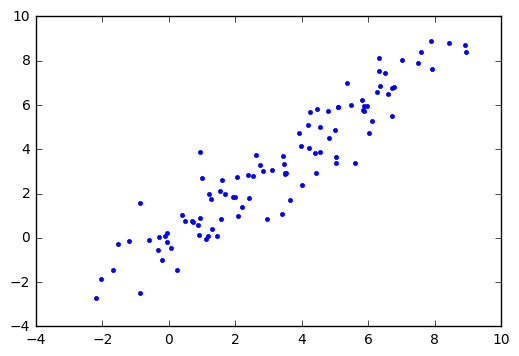

In [9]:
#plot
preds = lm.predict(X.iloc[:,:-1])

plt.plot(preds, X['target'], '.')

## Logistic Regression

Let $y \in \{0, 1\}$ be a random variable (the target) and $X = x_1, \ldots, x_p$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{Ber}(p)
$$
where
$$
p = p(X) = f(w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p)
$$
and $f$ is the _logistic function_
$$
f(t) = \frac{1}{1 + e^{-t}}
$$

### Logistic Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set p = 3
2. Choose a formula for $p(X)$
$$
p(X) = f(5 - 9 x_1 + 3 x_2 + 2 x_3)
$$

#### Exercise: Generate logistic regression data according to the model above.

In [10]:
np.random.binomial(n = 3, p = .1)

1

In [11]:
#drop original target
del X['target']

def sigmoid(t):
    return 1 / (1 + np.exp(-t))


def make_target_logistic(row):
    """
    Return either 0 or 1, according to a Bernoulli distribution defined by row.
    """
    x, y, z = row[0], row[1], row[2]
    t = 5 - 9*x + 3*y + 2*z
    p = sigmoid(t)
    
    return np.random.binomial(n = 1, p = p)


X['target'] = X.apply(lambda row: make_target_logistic(row), axis = 1)

X.head()

,0,1,2,target
0,0.062885,0.177974,0.746400,1
1,0.400408,0.489828,0.583214,1
2,0.586627,0.818786,0.757389,1
3,0.276453,0.638867,0.263531,1
4,0.891210,0.989808,0.684017,0


#### Recover coefficients

In [12]:
from sklearn.linear_model import LogisticRegression

# Fit logistic model
logit = LogisticRegression(C=1e18)
logit.fit(X.iloc[:,:-1], X['target'])

print "Intercept: {:.3}".format(logit.intercept_)

print 'Coeffs: ', logit.coef_

print 'Accuracy: {:.3}'.format(logit.score(X.iloc[:, :-1], X['target']))

Intercept: [ 8
Coeffs:  [[-12.52121029   4.40235424  -1.89670427]]
Accuracy: 0.88


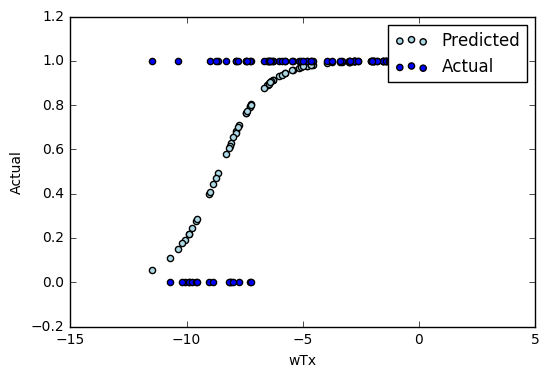

In [13]:
results = pd.DataFrame({
        'wTx': X.apply(lambda row: np.dot(row[:3], logit.coef_.flatten()), axis=1),
        'Predicted Probability': logit.predict_proba(X.iloc[:, :-1])[:,1],
        'Actual': X['target']
    })

ax = results.plot(x='wTx', y='Predicted Probability', kind='scatter', 
                  label = 'Predicted', color='lightblue')
results.plot(x='wTx', y='Actual', kind='scatter', ax=ax, label='Actual')

# Regularization

For any type of regression, one learns the model parameters by:

1. Assume the probabilistic model is correct.
2. Compute the _likelihood_ of each data point for a given set of parameters $w_0, \ldots, w_p$. (just evaluate the PDF at that point and target value)
3. Choose the set of parameters that maximizes the total likelihood. (or, equivalently, minimizes the log-likelihood)

For linear regression, it turns out that ${\cal l} (X) \sim ||w^T x - y||^2$. So maximizing the likelihood is the same as minimizing the mean-squared error.

For logistic regression,
$$
{\cal l} (x) := -y \log(f(w^T x)) - (1 - y) \log(1 - f(w^Tx))
$$

In either case, regularization just means that instead of directly minimizing ${\cal L}(X)$, we also add a penalty on the size of coefficients.

#### L1 (Lasso) Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + \lambda \sum_{i=1}^p |w_i|
$$

#### L2 (Ridge) Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + \lambda \sum_{i=1}^p ||w_i||^2
$$

#### Elastic Net Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + (1 - \alpha) \cdot \lambda \sum_{i=1}^p |w_i|^2 + \alpha \cdot \lambda \sum_{i=1}^p ||w_i||
$$

# Application: Crime Data

In [24]:
from sklearn.model_selection import train_test_split

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
         .iloc[:, 5:]
         .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
train_df, test_df = train_test_split(crime, random_state=2)

## Exercise: 

1. Fit a linear regression model on train_df. The goal is to predict 'ViolentCrimesPerPop' from the other columns. What is the r-squared on the train data? What about the test data?
2. Also fit each of a ridge, lasso, and elastic net regression on the same data. Use the functions RidgeCV, LassoCV, and ElasticNetCV to cross-validate and find the best values of $\lambda$ and $\alpha$.
3. Which model performs the best?

### Linear Regression

In [28]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV 

#instantiate the classifier
lm =  LinearRegression()

#fit
lm.fit(train_df[predictors], train_df[target])

#predict
lm.predict(test_df[predictors])

#score
print "Test Data Score: " + str(lm.score(test_df[predictors], test_df[target]))
print "Train Data Score: " + str(lm.score(train_df[predictors], train_df[target]))





Test Data Score: 0.509165466859
Train Data Score: 0.823186169403


### Ridge

In [62]:
#instantiate cross validation functions
alphas = np.arange(0.01, 60, 0.01)

ridge = RidgeCV(alphas = alphas, store_cv_values = True)
lasso = LassoCV(alphas = alphas)
elasticnet = ElasticNetCV(alphas = alphas)


In [63]:
#fit the model to the training data
ridge.fit(train_df[predictors], train_df[target])

print "Test Data Score: " + str(ridge.score(test_df[predictors], test_df[target]))
print "Train Data Score: " + str(ridge.score(train_df[predictors], train_df[target]))

print ridge.alpha_


Test Data Score: 0.712620264967
Train Data Score: 0.660786311225
11.77


11.77


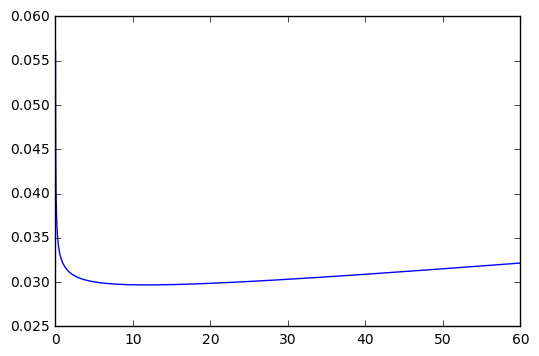

In [67]:
#get mean log likelihoods
mean_log_likelihood = np.mean(ridge.cv_values_, axis = 0)

#get index of 
min_index = np.argmin(mean_log_likelihood)

#see if the alpha in the list corresponding to 
print alphas[min_index]

#Plot alpha
plt.plot(alphas, mean_log_likelihood)


### Lasso

In [47]:
#fit the model to the training data
lasso.fit(train_df[predictors], train_df[target])

print "Test Data Score: " + str(lasso.score(test_df[predictors], test_df[target]))
print "Train Data Score: " + str(lasso.score(train_df[predictors], train_df[target]))


Test Data Score: 0.623387682963
Train Data Score: 0.560993785665


### Elastic Net

In [ ]:
#fit the model to the training data
lasso.fit(train_df[predictors], train_df[target])

print "Test Data Score: " + str(lasso.score(test_df[predictors], test_df[target]))
print "Train Data Score: " + str(lasso.score(train_df[predictors], train_df[target]))


## Exercise:

1. Make the following scatterplot
    - Each point corresponds to one predictor in the data
    - The x-value is the coefficient of that predictor under OLS regression
    - The y-value is the coefficient of that predictor using ridge regularization
2. Do the same for OLS vs Lasso, and OLS vs ElasticNet

## Question: 

What is the story with the two 'large coefficients' found by OLS that are squashed by regularization? (You may have to do some digging)

## Question:

Can we tell from this process which predictors are _the most important_ for predicting violent crimes?